In [1]:
# Import packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm

### Get location IDs to use for query

In [2]:
BASE_URL_LOCATION = "https://www.metaweather.com/api/location/search/?query="

In [3]:
cities = {
    "San Francisco": None,
    "Seoul": None,
    "Chennai": None,
    "Cape Town": None
}

In [4]:
for city in cities.keys():
    payload = requests.get(BASE_URL_LOCATION + city.lower().replace(" ", "+")).json()
    cities[city] = payload[0]["woeid"]

In [5]:
cities

{'San Francisco': 2487956,
 'Seoul': 1132599,
 'Chennai': 2295424,
 'Cape Town': 1591691}

### Get weather for the different locations

In [6]:
BASE_URL_WEATHER = "https://www.metaweather.com/api/location/"

In [7]:
curr_weather = []

for city, woe_id in cities.items():
    payload = requests.get(BASE_URL_WEATHER + str(woe_id)).json()
    curr_weather.append(
        {
            "time_utc": payload["consolidated_weather"][0]["created"],
            "location": city,
            "temperature_c": payload["consolidated_weather"][0]["the_temp"],
            "weather_state": payload["consolidated_weather"][0]["weather_state_name"]
        }
    )

In [8]:
pd.DataFrame(curr_weather)

,time_utc,location,temperature_c,weather_state
0,2022-01-21T00:59:16.170250Z,San Francisco,15.595,Clear
1,2022-01-21T01:09:37.169183Z,Seoul,0.985,Light Cloud
2,2022-01-20T23:34:40.766396Z,Chennai,27.940,Heavy Cloud
3,2022-01-21T00:06:14.545005Z,Cape Town,28.095,Clear


### Load and Append to DataFrame

In [9]:
try:
    df = pd.read_csv("weather_locations.csv")
    df = df.append(pd.DataFrame(curr_weather))
except Exception:
    # Create DataFrame on first run
    df = pd.DataFrame(curr_weather)
    
# Drop duplicate rows
df = df.drop_duplicates()
    
# Save new CSV
df.to_csv("weather_locations.csv", index=False)

### Dynamically Load Font `Lato`

In [5]:
font_path = "./fonts/Lato-Regular.ttf"

fm.fontManager.addfont(font_path)
fm.FontProperties(fname=font_path)

### Plot Data

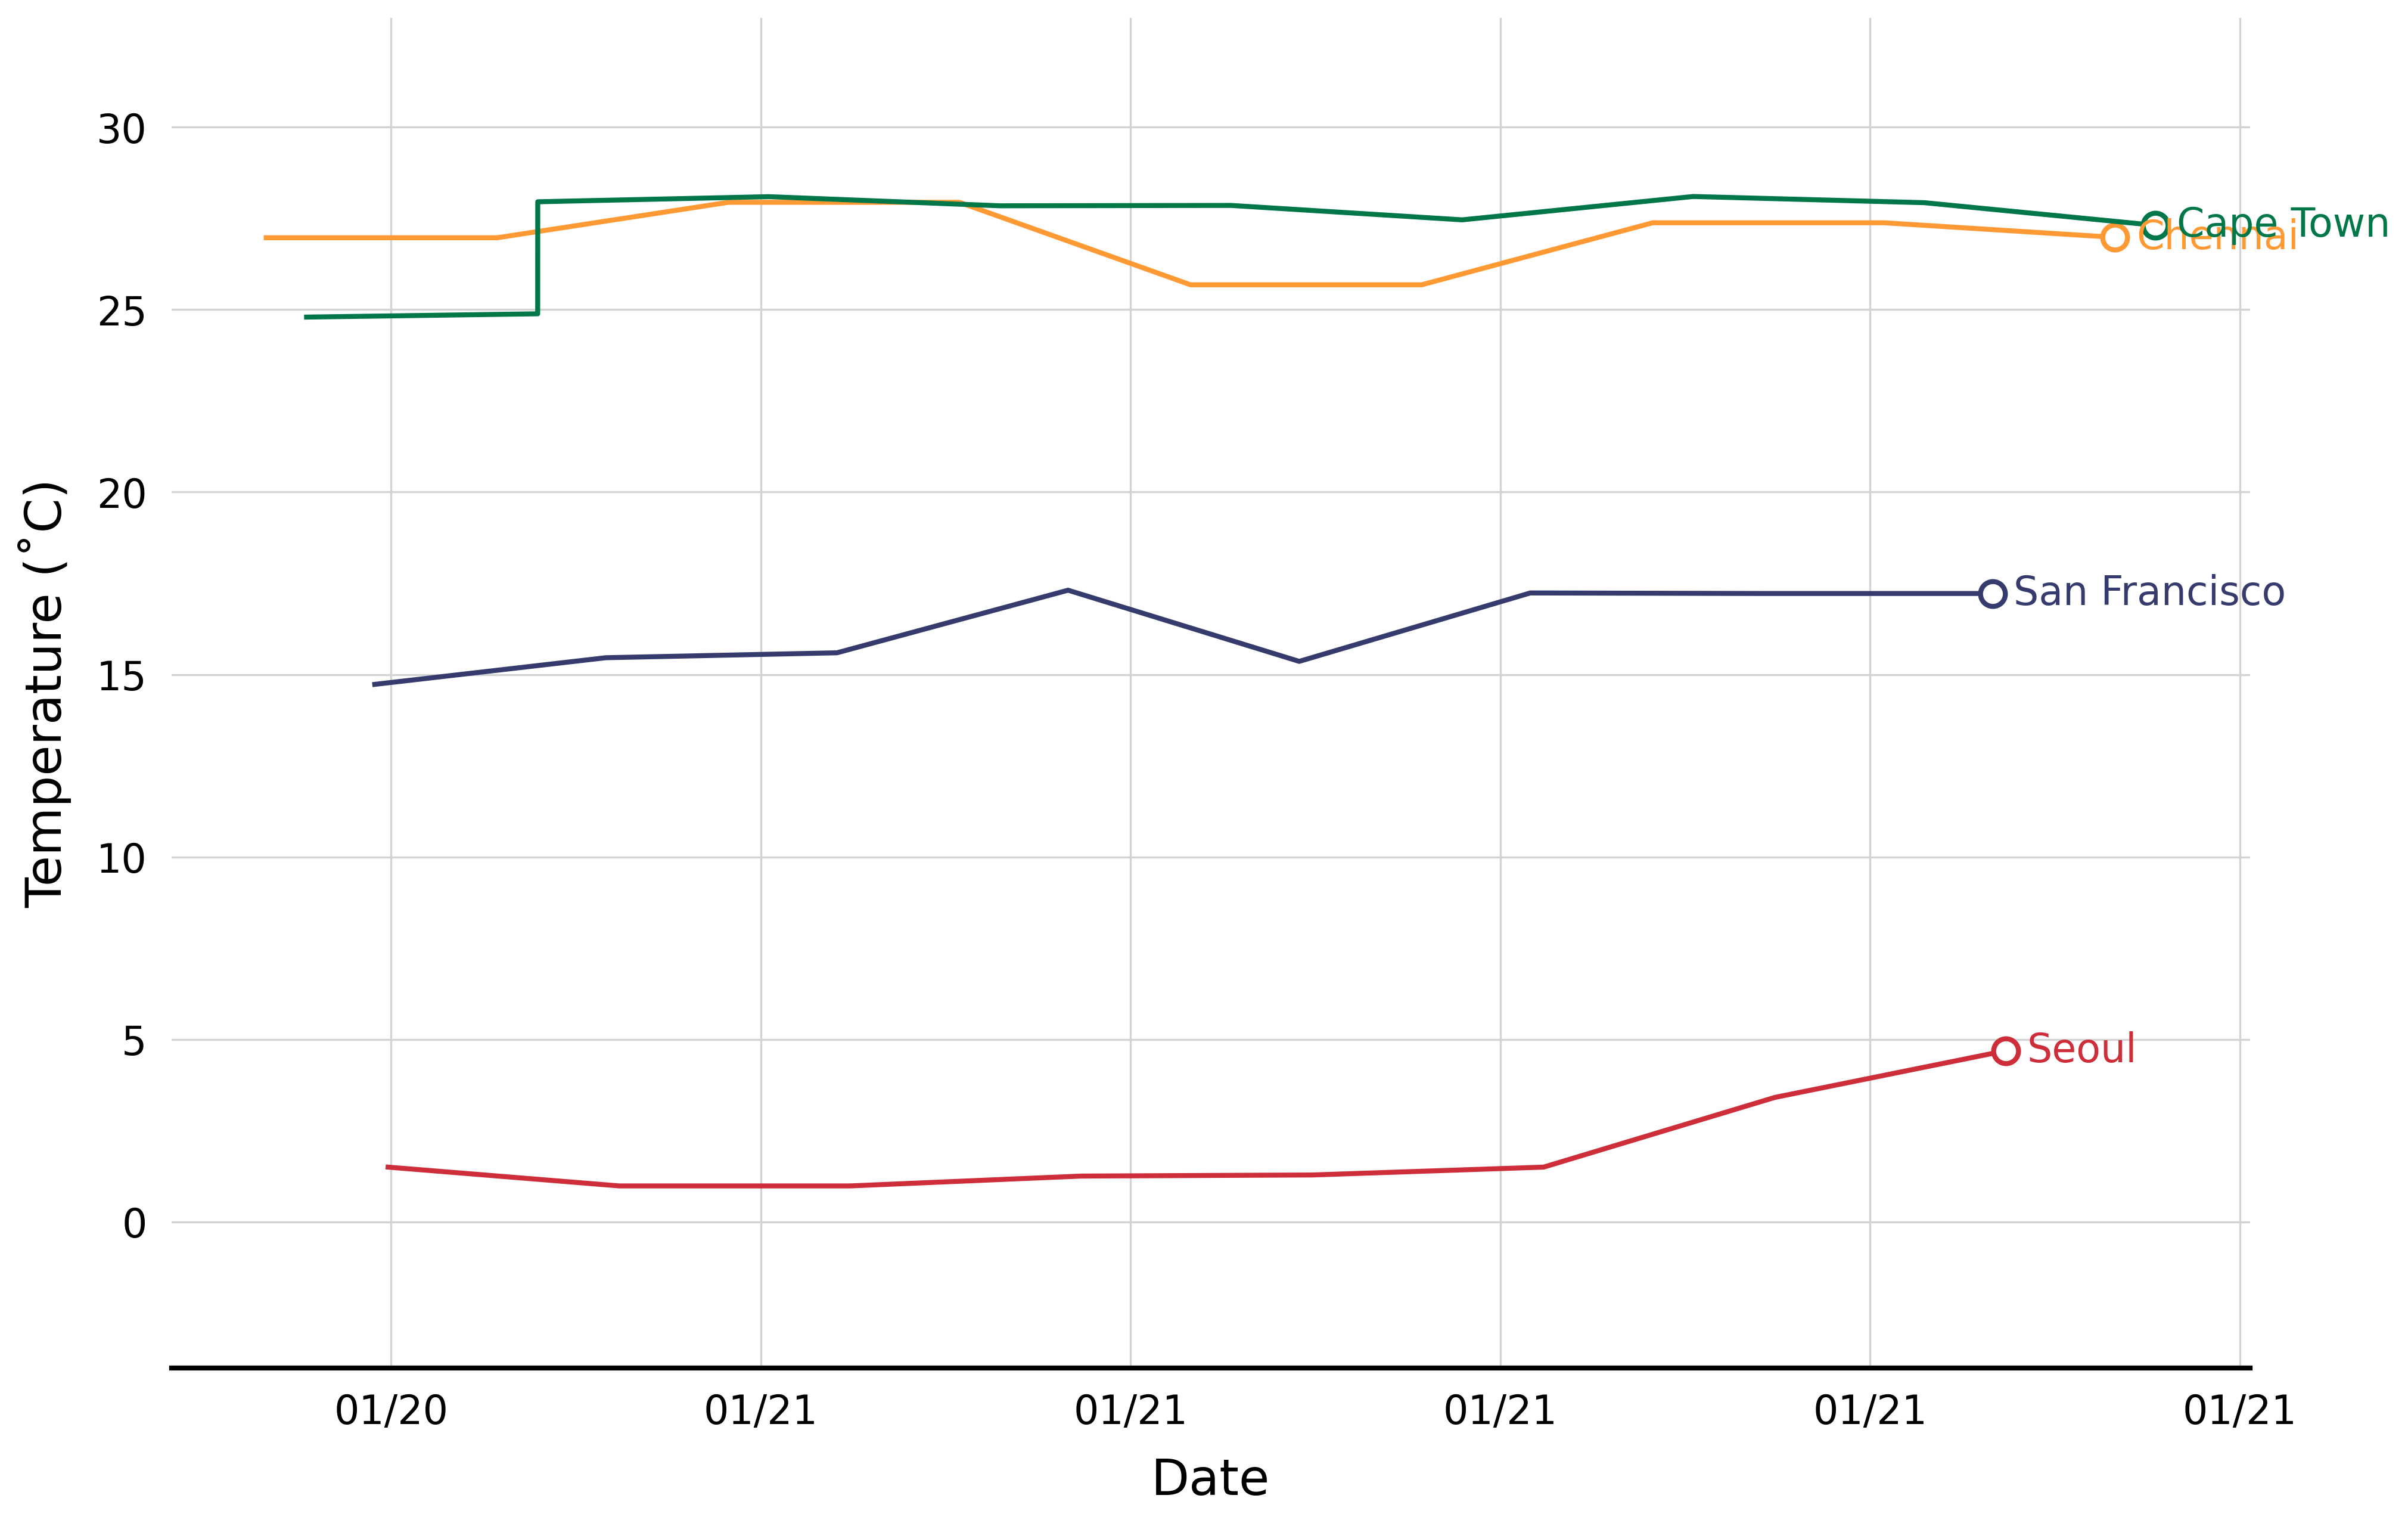

In [9]:
plt.rcParams["font.family"] = "Lato"
plt.rcParams["font.size"] = 16
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["xtick.major.pad"] = 10
plt.rcParams["ytick.major.size"] = 0
plt.rcParams["ytick.major.pad"] = 10

colors = {
    "San Francisco": "#363b6e",
    "Seoul": "#cd2e3a",
    "Chennai": "#ff9933",
    "Cape Town": "#007749"
}

fig = plt.figure(figsize=(15, 10), dpi=300, facecolor="white")
ax = fig.add_subplot(111)
ax.grid(color="#d3d3d3")
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Load DataFrame
df = pd.read_csv("weather_locations.csv")

# Convert date column to datetime
df.time_utc = df.time_utc.apply(lambda t: pd.to_datetime(str(t)))

# Sort values by time
df = df.sort_values("time_utc")

# Convert data to pixels
DC_to_FC = ax.transData.transform
FC_to_DC = ax.transData.inverted().transform

# Plot Data
for city in cities.keys():
    df_temp = df[df["location"] == city].reset_index(drop=True).copy()
    ax.plot(
        mdates.date2num(df_temp["time_utc"]), df_temp["temperature_c"], 
        color=colors[city],
        lw=2, 
        markevery=[-1], 
        marker="o", 
        ms=10, 
        mew=2, 
        mfc="white"
    )

# Add labels
for city in cities.keys():
    df_temp = df[df["location"] == city].reset_index(drop=True).copy()
    coords_original = [mdates.date2num(df_temp.iloc[-1].time_utc), df_temp.iloc[-1].temperature_c]
    coords_transformed = DC_to_FC(coords_original)
    
    # Pad 40 pixels between last point and label
    coords_transformed[0] += 40
    coords_new = FC_to_DC(coords_transformed)
    ax.text(coords_new[0], coords_new[1], city, ha="left", va="center", color=colors[city])

# Tick Label Format
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

# Axis Labels
ax.set_xlabel("Date", labelpad=10, size=20)
ax.set_ylabel("Temperature (˚C)", labelpad=10, size=20)

# Axis Limits
ax.set_ylim(min(df.temperature_c.round(0)) - 5, max(df.temperature_c.round(0) + 5))

plt.savefig("weather_locations.png", dpi=300, bbox_inches="tight")
plt.show()